In [1]:
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
import matplotlib.pyplot as plt
import pandas as pd
import math
import pickle
import time
import datetime
import random
from pprint import pprint

from SVD import Metrics, SVDPredictor, LogisticSVD
from RecData import RecData

In [2]:
recs = pd.read_csv('data/pruned.csv')
USED_COLS = ['app_id', 'is_recommended', 'user_id']
recs = recs[USED_COLS]

item_data = pd.read_csv('data/games.csv')
titles = item_data[['app_id', 'title']]

recs.head()

,app_id,is_recommended,user_id
0,534380,True,10531
1,42700,False,185293
2,602960,True,319249
3,976730,False,747545
4,1091500,True,2113544


In [3]:
random.seed(42)
np.random.seed(42)

rec_data = RecData()
rec_data.create_from_dataframe(recs)
rec_data.set_titles(titles)

train_data, test = rec_data.leave_k_out_split()
train_data, val = train_data.leave_k_out_split()

Epoch 0/Training error: 0.49716507862517273/Validation error: 0.485129721655772/Time: 80.95 seconds
Epoch 1/Training error: 0.4971341338318508/Validation error: 0.4851188556432665/Time: 73.39 seconds
Epoch 2/Training error: 0.49685817056523196/Validation error: 0.4849552210496214/Time: 82.41 seconds
Epoch 3/Training error: 0.49307863397502705/Validation error: 0.4825079847296903/Time: 73.12 seconds
Epoch 4/Training error: 0.46047521335881847/Validation error: 0.4602954665394952/Time: 74.72 seconds
Epoch 5/Training error: 0.41458602878200934/Validation error: 0.4265932815966013/Time: 82.36 seconds
Epoch 6/Training error: 0.3937600131757906/Validation error: 0.41153799725831675/Time: 90.29 seconds
Epoch 7/Training error: 0.38415628776887345/Validation error: 0.4049851276616542/Time: 85.25 seconds
Epoch 8/Training error: 0.37802380071395053/Validation error: 0.4014596769552647/Time: 73.07 seconds
Epoch 9/Training error: 0.373460455259864/Validation error: 0.3991306996960375/Time: 84.94 se

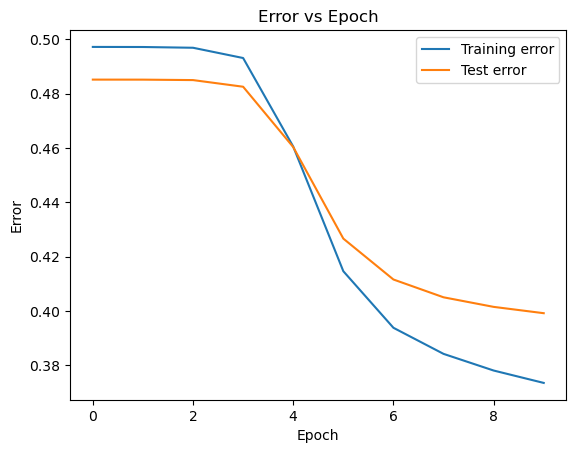

Test rmse 1.0754679486696397
Saving model...
Done saving model.


In [42]:
EPOCHS = 10

random.seed(42)
np.random.seed(42)

# Fit and predict with svd
svd_predictor = LogisticSVD(
    train_data.get_num_users(), train_data.get_num_items(), 2, k=50, epochs=EPOCHS, 
    learning_rate=0.05, C=0.03)
svd_predictor.fit(train_data.get_matrix(), validation_set=val)

# Plot error
errors = svd_predictor.get_train_errors()
val_errors = svd_predictor.get_val_errors()
plt.plot(range(len(errors)), errors, label='Training error')
plt.plot(range(len(val_errors)), val_errors, label='Test error')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.title('Error vs Epoch')
plt.legend()
plt.show()

# Compute rmse
predictions = svd_predictor.predict_pairs([(user, item) for user, item, _ in val])
predictions = [prediction + (val[i][2],) for i, prediction in enumerate(predictions)]
metrics = Metrics()
rmse = metrics.rmse(predictions)
print("Test rmse", rmse)

# Ensure file exists
model_dir = model_dir = "saved_models/{}-{}-{}-{}-{}-{}_{}".format(
    *(time.localtime()[:6] + (round(rmse, 4), ))).replace(".", "-") + ".pkl" 
file = open(model_dir, 'a')
file.close()

# Save model
print("Saving model...")
with open(model_dir, 'wb') as file:
    pickle.dump([svd_predictor, rec_data, train_data, val, test], file)
print("Done saving model.")

In [5]:
svd_predictor._user_biases[11, 0]

0.0

In [41]:
j = 20
# Test top-n list for user j
top_n = svd_predictor.top_n(j, 10)
print("Predicted top n:")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])

# User j true top n list
print("True top n:")
true_top = rec_data.top_n(j, 5000)
pprint([rec_data.index_to_title(index) for _, index in true_top])

Predicted top n:
[(0.8891179596887206, 'A Hat in Time'),
 (0.8856199132098099, 'Lil Gator Game'),
 (0.8846733438916083, 'Neon White'),
 (0.8809847601693596, 'POSTAL 2'),
 (0.8787738087353111, 'Turing Complete'),
 (0.8785055487631032, 'OMORI'),
 (0.8774603178641449, 'Outer Wilds'),
 (0.8766262324177647, 'Re-Volt'),
 (0.8765368582695121, 'Portal 2'),
 (0.8757428772356959, 'Bastion')]
True top n:
['Counter-Strike: Source',
 'Left 4 Dead 2',
 'Resident Evil 5',
 'Outlast',
 'Geometry Dash',
 'Wallpaper Engine',
 'Friday the 13th: The Game',
 'Phasmophobia',
 'DOOM Eternal',
 'Resident Evil 2',
 'Halo: The Master Chief Collection',
 'Resident Evil Village',
 '[NINJA GAIDEN: Master Collection] NINJA GAIDEN Σ2',
 'Rust',
 'Call of Duty®: Modern Warfare® II']


In [38]:
rec_data.search_title('portal')

[('portal 2', 11), ('desktop portal', 1582), ('portal', 6)]

In [21]:
prefs = [(606, 1), (1628, 1), (391, 0), (1330, 0), (500, 0), (709, 1), (840, 0), 
         (58, 1), (456, 1), (153, 0), (158, 0), (1160, 0), (761, 0),
                              (1771, 0), (544, 0), (312, 0), (277, 0)]
pprint([(index, rec_data.index_to_title(index), pref) for index, pref in prefs])
prefs = rec_data.create_prefs(prefs)    

[(606, 'Stardew Valley', 1),
 (1628, 'The Sims™ 4', 1),
 (391, 'Mortal Kombat X', 0),
 (1330, 'Mortal Kombat\xa011', 0),
 (500, 'Total War: WARHAMMER', 0),
 (709, 'UNO', 1),
 (840, 'MONOPOLY® PLUS', 0),
 (58, 'SPORE™', 1),
 (456, 'Choice of Robots', 1),
 (153, 'Infested Planet', 0),
 (158, 'Gunpoint', 0),
 (1160, 'Cosmoteer: Starship Architect & Commander', 0),
 (761, 'Glass Masquerade', 0),
 (1771, 'Against the Storm', 0),
 (544, 'Aviary Attorney', 0),
 (312, 'Grand Theft Auto V', 0),
 (277, 'Rust', 0)]


In [22]:
svd_predictor._partial_batch_size = int(0)
start_time = time.time()
svd_predictor.partial_fit(prefs)
print("Completed partial fit in", time.time() - start_time, "seconds")

Epoch 0/Training error: 0.21518263409250585/Time: 25.66 seconds
Epoch 1/Training error: 0.21518263409250585/Time: 25.95 seconds
Epoch 2/Training error: 0.21518263409250585/Time: 26.65 seconds
Epoch 3/Training error: 0.21518263409250585/Time: 26.24 seconds
Epoch 4/Training error: 0.21518263409250585/Time: 25.68 seconds
Epoch 5/Training error: 0.21518263409250585/Time: 25.83 seconds
Epoch 6/Training error: 0.21518263409250585/Time: 26.17 seconds
Epoch 7/Training error: 0.21518263409250585/Time: 25.22 seconds
Epoch 8/Training error: 0.21518263409250585/Time: 26.65 seconds
Epoch 9/Training error: 0.21518263409250585/Time: 26.91 seconds
Epoch 10/Training error: 0.21518263409250585/Time: 25.53 seconds
Epoch 11/Training error: 0.21518263409250585/Time: 26.03 seconds
Epoch 12/Training error: 0.21518263409250585/Time: 26.3 seconds
Epoch 13/Training error: 0.21518263409250585/Time: 26.55 seconds
Epoch 14/Training error: 0.21518263409250585/Time: 26.52 seconds
Epoch 15/Training error: 0.215182634

In [23]:
top_n = svd_predictor.top_n(train_data.get_matrix().shape[0], 20)
print("Predicted top n")
pprint([(r, train_data.index_to_title(index)) for r, index in top_n])

Predicted top n
[(0.9908499777686517, 'eFootball™ 2023'),
 (0.9814174079790924, 'Battlefield™ 2042'),
 (0.972738549814746, 'Rugby 22'),
 (0.9691302801641789, 'PUBG: BATTLEGROUNDS'),
 (0.9678884481501989, 'Z1 Battle Royale'),
 (0.9630763549674729, 'BIOMUTANT'),
 (0.9627740839451867, 'ICARUS'),
 (0.9619426469797, 'Might & Magic X - Legacy'),
 (0.9611264122200068, "Assassin's Creed Valhalla"),
 (0.9608861532025795, 'End State'),
 (0.9553479142064581, 'Another Farm Roguelike'),
 (0.947986676641079, 'Arcade Spirits: The New Challengers'),
 (0.9468602401406665, 'Back 4 Blood'),
 (0.943875484980961, 'Trackmania® Turbo'),
 (0.9369798273136265, 'Generation Zero®'),
 (0.935710298813653, 'ATLAS'),
 (0.9355139991920496, 'Fhtagn Simulator'),
 (0.9259984095767555, 'FOR HONOR™'),
 (0.9204974604784083, 'Animalia Survival'),
 (0.9186543313705807, 'Silent Hill Homecoming')]
